In [1]:
# Import libraries
import os
import sys

import pandas as pd
import numpy as np

import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras import backend as K

Using TensorFlow backend.


In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
# Set up paths
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
src_folder = os.path.join(project_root, 'src')

In [5]:
# Import src functions
sys.path.insert(0, src_folder)
from stats_and_visualisations import *
from s3_storage import *

In [8]:
# Import data
X_train = from_s3(bucket='mimic-jamesi', filepath='data/acute_kidney_failure_X_train.npy')
X_test = from_s3(bucket='mimic-jamesi', filepath='data/acute_kidney_failure_X_test.npy')
y_train = from_s3(bucket='mimic-jamesi', filepath='data/acute_kidney_failure_y_train.npy')
y_test = from_s3(bucket='mimic-jamesi', filepath='data/acute_kidney_failure_y_test.npy')
print('--> Importing done')

--> Importing done


In [9]:
# Split into training and cross validarion sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=8)
print('--> Training & Validation sets created')

--> Training & Validation sets created


In [10]:
### ----- OPTIONS
epochs=500
batch_size=100

In [11]:
# Function to create model, required for KerasClassifier
def create_model(input_shape, neurons=1000, weight_constraint=3, dropout_rate=0.1,
                 hidden_layers=1, learn_rate=0.001, momentum=0.1):
        
    # Initialize the constructor
    model = Sequential()
    
    # Add an input layer
    model.add(Dense(neurons,
                    input_shape=input_shape,
                    activation='relu',
                    kernel_initializer = 'normal',
                    kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))

    for i in range(hidden_layers):
        # Add one hidden layer
        model.add(Dense(neurons,
                        activation='relu',
                        kernel_initializer = 'normal',
                        kernel_constraint=maxnorm(weight_constraint)))
        model.add(Dropout(dropout_rate))

    # Add an output layer 
    model.add(Dense(1, kernel_initializer = 'normal', activation='sigmoid'))
    
    #compile model
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [12]:
def plot_accuracy_by_epoch(df, x_axis='epochs', display_points=50):
    
    if x_axis == 'lr':
        x_labels = df['lr'].tolist()
    else:
        x_labels = df['epoch'].tolist()
    
    x_len = len(x_labels)
    x = np.arange(x_len)
    x_ticks_n = int(np.ceil(x_len/display_points))
    
    # summarize history for accuracy
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.plot(x, df['acc'], label='train')
    ax.plot(x, df['val_acc'], label='valid')
    ax.xaxis.set_ticks(x)
    ax.xaxis.set_ticklabels(x_labels)
    plt.xticks(rotation='vertical')
    plt.legend()
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel(x_axis)
    
    for index, label in enumerate(ax.xaxis.get_ticklabels()):
        if index % x_ticks_n != 0:
            label.set_visible(False)
    for index, label in enumerate(ax.xaxis.get_ticklines()):
        if index % x_ticks_n != 0:
            label.set_visible(False)
    
    plt.show()
    
    # summarize history for loss
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.plot(x, df['loss'], label='train')
    ax.plot(x, df['val_loss'], label='valid')
    ax.xaxis.set_ticks(x)
    ax.xaxis.set_ticklabels(x_labels)
    plt.xticks(rotation='vertical')
    plt.legend()
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel(x_axis)
    
    for index, label in enumerate(ax.xaxis.get_ticklabels()):
        if index % x_ticks_n != 0:
            label.set_visible(False)
    for index, label in enumerate(ax.xaxis.get_ticklines()):
        if index % x_ticks_n != 0:
            label.set_visible(False)
    
    plt.show()

In [13]:
def train_model(X_train, y_train, X_val, y_val, epochs, batch_size, params={}, lr_annealing=False, lr_multiplier=1):
    
    print('------------')
    print('Params: ', params)
    
    params['input_shape'] = (X_train.shape[1],)
    
    model = create_model(**params)

    # Find the class weights so predictions match these weights
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

    # Train the model
    history = pd.DataFrame(columns=['epoch', 'lr', 'acc', 'loss', 'val_acc', 'val_loss'])
    
    for e in range(epochs):
        
        history_tmp = model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=0,
                                class_weight=class_weights, validation_data=(X_val, y_val))
        
        history.loc[e, 'epoch'] = e + 1
        history.loc[e, 'lr'] = round(K.get_value(model.optimizer.lr),4)
        history.loc[e, 'acc'] = history_tmp.history['acc'][0]
        history.loc[e, 'loss'] = history_tmp.history['loss'][0]
        history.loc[e, 'val_acc'] = history_tmp.history['val_acc'][0]
        history.loc[e, 'val_loss'] = history_tmp.history['val_loss'][0]
        
        # Raise the learning rate
        if lr_annealing:
            new_lr = lr_multiplier * K.get_value(model.optimizer.lr)
            K.set_value(model.optimizer.lr, new_lr)
        
    # Visualise accuracy and loss by epoch
    if lr_annealing:
        plot_accuracy_by_epoch(history, x_axis='lr')
    else:
        plot_accuracy_by_epoch(history)
    
    train_predictions = model.predict(X_train)
    valid_predictions = model.predict(X_val)

    train_score = roc_auc_score(y_train, train_predictions)
    valid_score = roc_auc_score(y_val, valid_predictions)

    print('--> Training score: ', train_score)
    print('--> Valid score: ', valid_score)
        
    return train_score, valid_score, model

In [14]:
def plot_neural_net_hyperparam(results_df, hyperparam, train_score, valid_score):

    x_labels = results_df[hyperparam].tolist()
    x = np.arange(len(x_labels))
    train = results_df[train_score].tolist()
    valid = results_df[valid_score].tolist()

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.plot(x, train, label='train')
    ax.plot(x, valid, label='valid')
    ax.xaxis.set_ticks(x)
    ax.xaxis.set_ticklabels(x_labels)
    plt.legend()
    plt.xlabel(hyperparam)
    plt.ylabel('Score')
    plt.title('Score vs {}'.format(hyperparam))
    plt.show()

## Learning Rate

------------
Params:  {'learn_rate': 0.0001, 'momentum': 0}


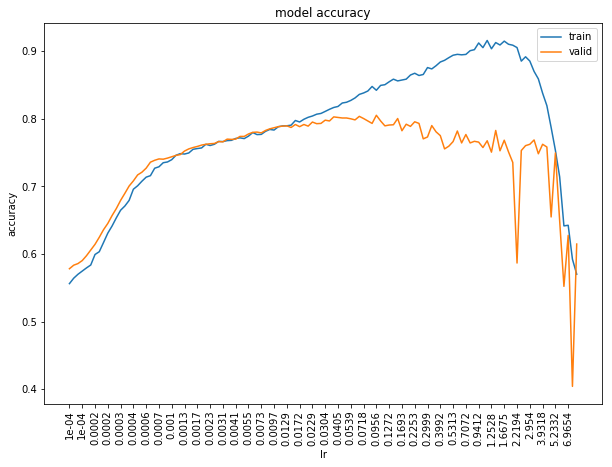

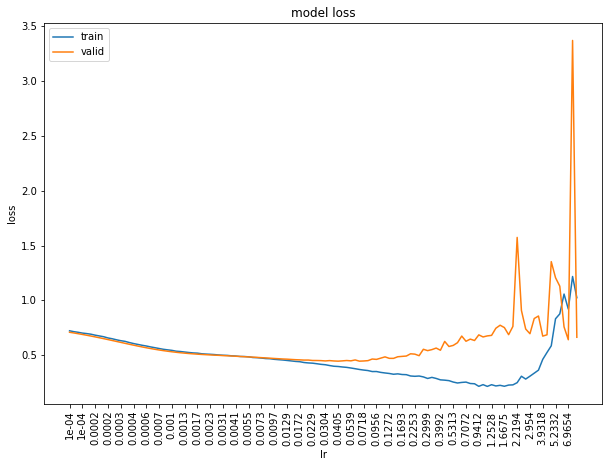

--> Training score:  0.5725091812164391
--> Valid score:  0.5591180298497371


In [15]:
train_score, valid_score, m = train_model(X_train, y_train, X_val, y_val, params={'learn_rate':0.0001, 'momentum':0},
                                          epochs=120, batch_size=batch_size, lr_annealing = True, lr_multiplier=1.1)

## Hidden Layers

------------
Params:  {'hidden_layers': 0, 'learn_rate': 0.07}


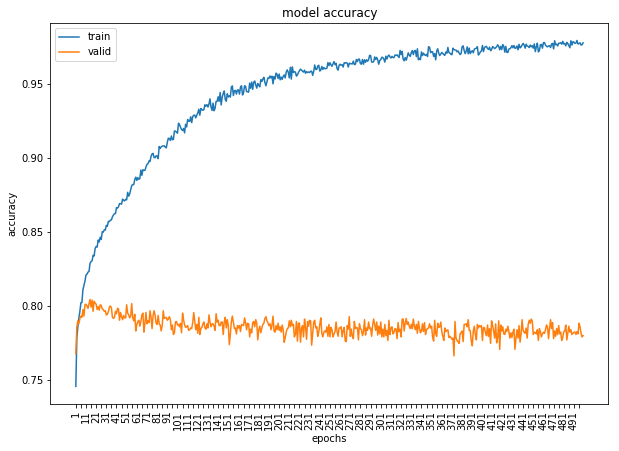

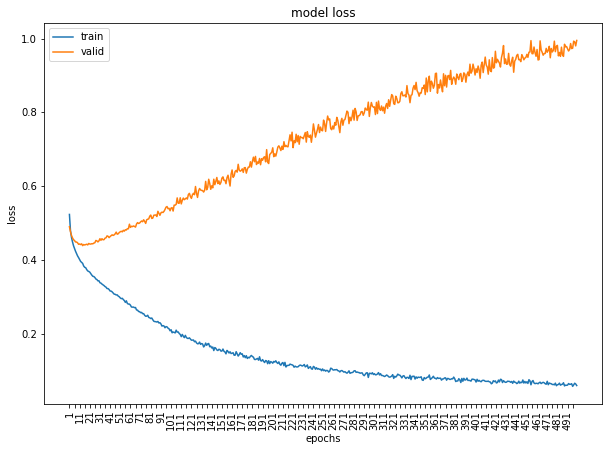

--> Training score:  0.999968094451543
--> Valid score:  0.8470621841353548
------------
Params:  {'hidden_layers': 1, 'learn_rate': 0.07}


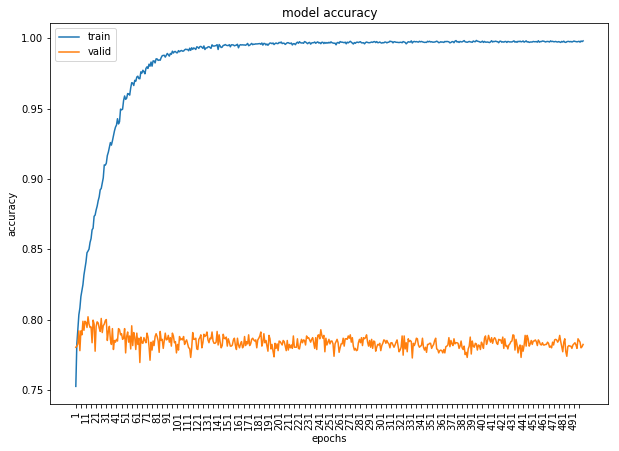

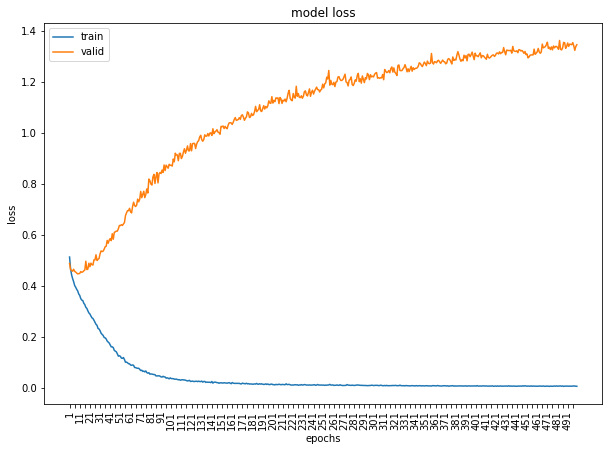

--> Training score:  0.9999865428082746
--> Valid score:  0.8413525345232663
------------
Params:  {'hidden_layers': 2, 'learn_rate': 0.07}


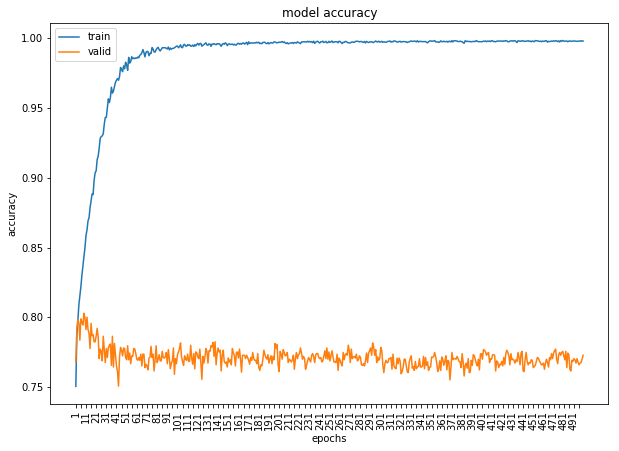

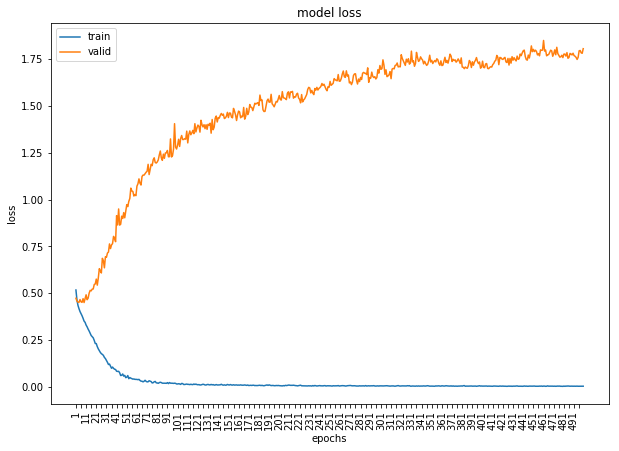

--> Training score:  0.9999866270473463
--> Valid score:  0.8338420972567314
===== Overall =====
  hidden_layers train_score valid_score
0             0    0.999968    0.847062
1             1    0.999987    0.841353
2             2    0.999987    0.833842


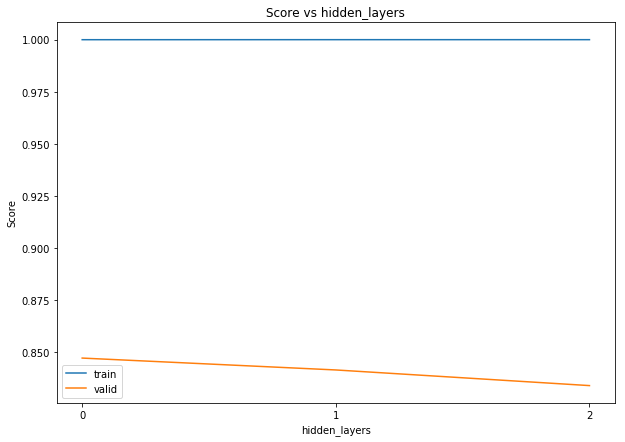

In [16]:
optimising_hyperparameter = 'hidden_layers'
values = [0, 1, 2]
results_df = pd.DataFrame(columns=[optimising_hyperparameter, 'train_score', 'valid_score'])

for ix,v in enumerate(values):
    
    params = {}
    params[optimising_hyperparameter] = v
    params['learn_rate'] = 0.05
    
    train_score, valid_score, m = train_model(X_train, y_train, X_val, y_val,
                                               params=params, epochs=epochs, batch_size=batch_size)
    
    results_df.loc[ix, optimising_hyperparameter] = v
    results_df.loc[ix, 'train_score'] = train_score
    results_df.loc[ix, 'valid_score'] = valid_score

print("===== Overall =====")
print(results_df)
plot_neural_net_hyperparam(results_df, optimising_hyperparameter, 'train_score', 'valid_score')

## Dropout

------------
Params:  {'dropout_rate': 0.8, 'learn_rate': 0.07, 'hidden_layers': 1}


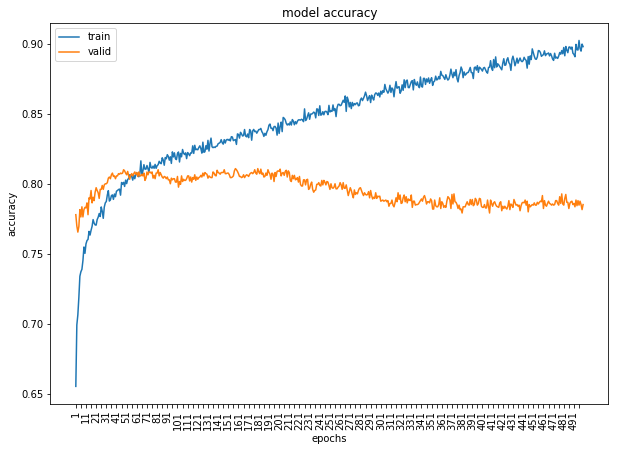

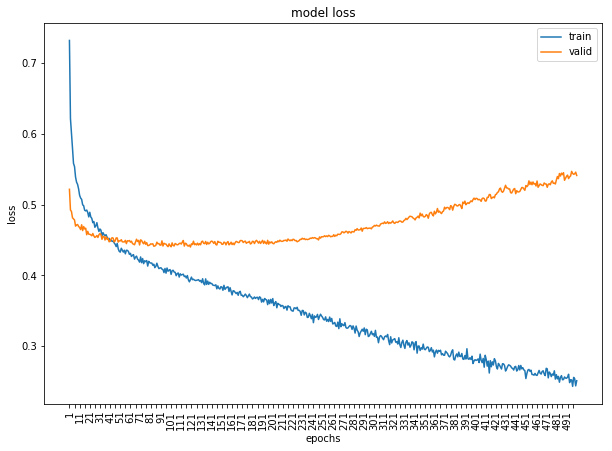

--> Training score:  0.9896260214829851
--> Valid score:  0.8542700674407993
------------
Params:  {'dropout_rate': 0.82, 'learn_rate': 0.07, 'hidden_layers': 1}


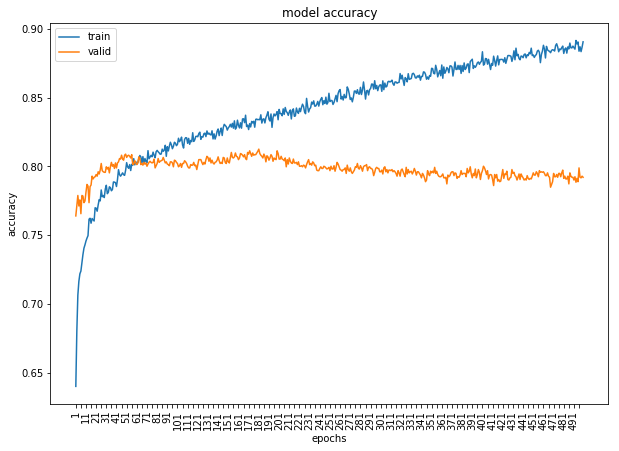

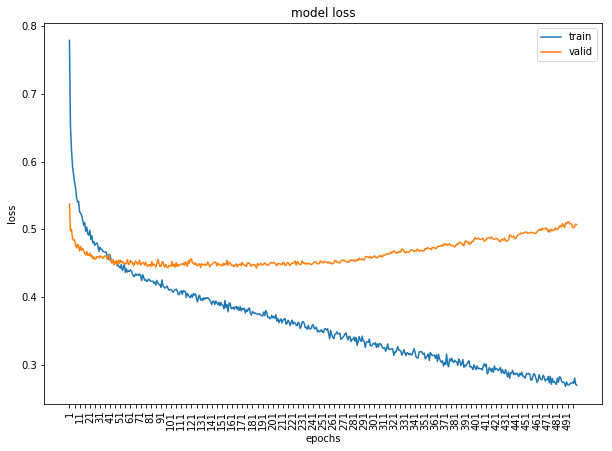

--> Training score:  0.9845406771945291
--> Valid score:  0.8534262968409309
------------
Params:  {'dropout_rate': 0.84, 'learn_rate': 0.07, 'hidden_layers': 1}


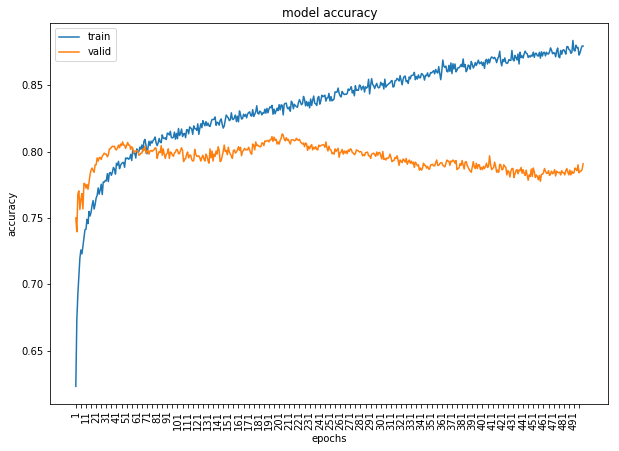

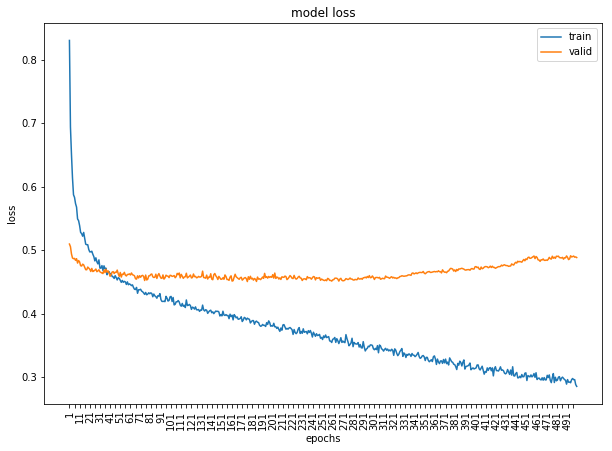

--> Training score:  0.9780582278997111
--> Valid score:  0.8567101059783987
------------
Params:  {'dropout_rate': 0.86, 'learn_rate': 0.07, 'hidden_layers': 1}


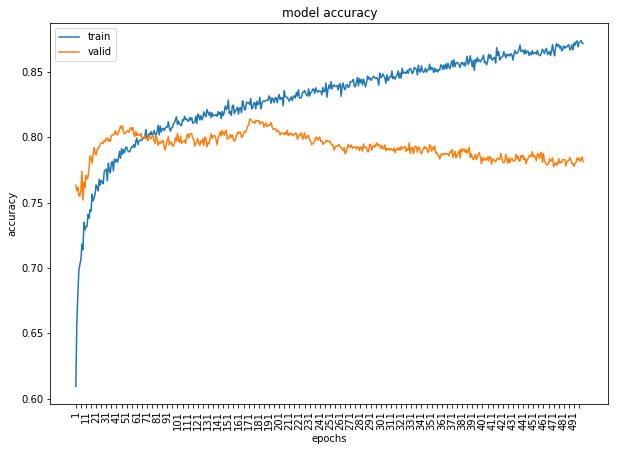

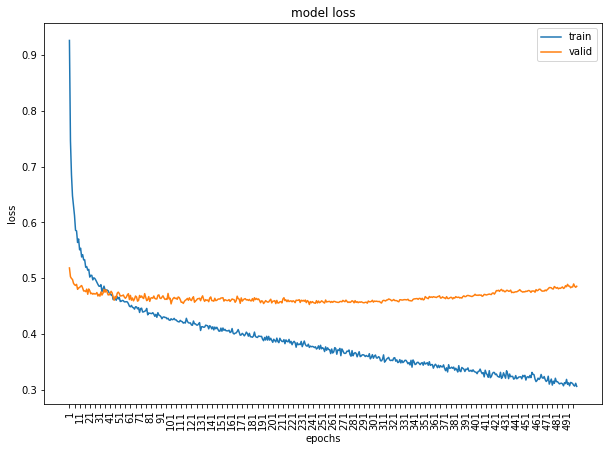

--> Training score:  0.9692829174281878
--> Valid score:  0.8565809712151176
------------
Params:  {'dropout_rate': 0.88, 'learn_rate': 0.07, 'hidden_layers': 1}


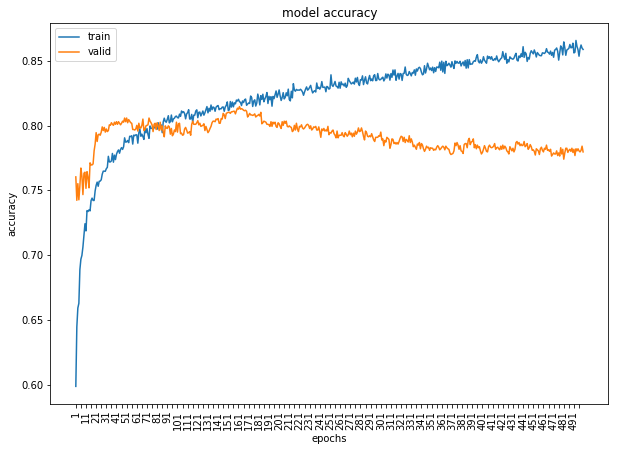

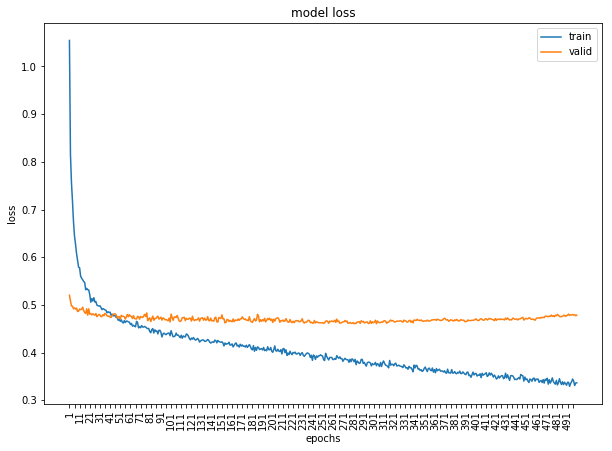

--> Training score:  0.9552673048955705
--> Valid score:  0.8658763078275273
------------
Params:  {'dropout_rate': 0.9, 'learn_rate': 0.07, 'hidden_layers': 1}


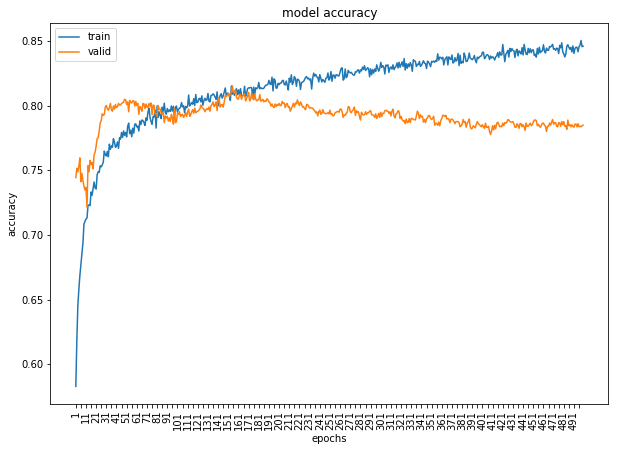

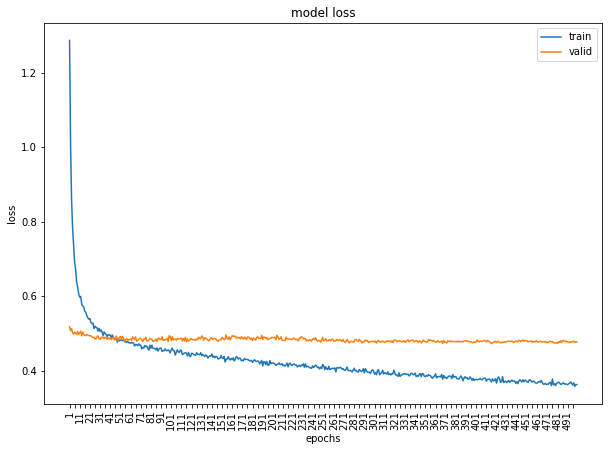

--> Training score:  0.9441806848906105
--> Valid score:  0.871174213613238
------------
Params:  {'dropout_rate': 0.92, 'learn_rate': 0.07, 'hidden_layers': 1}


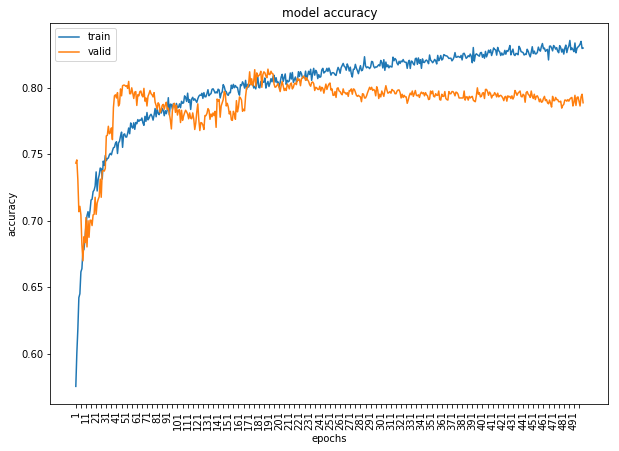

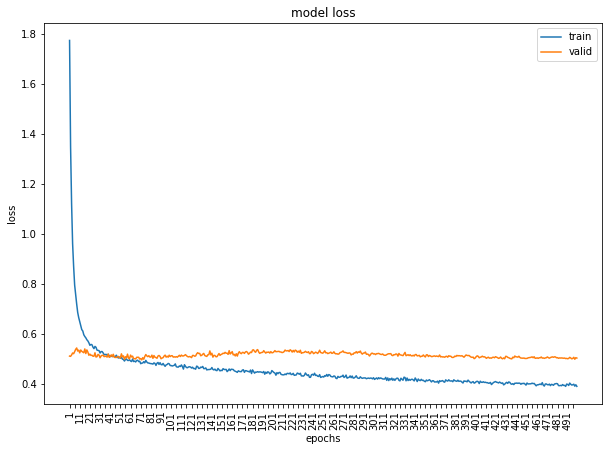

--> Training score:  0.9295452623272089
--> Valid score:  0.870467690955496
------------
Params:  {'dropout_rate': 0.94, 'learn_rate': 0.07, 'hidden_layers': 1}


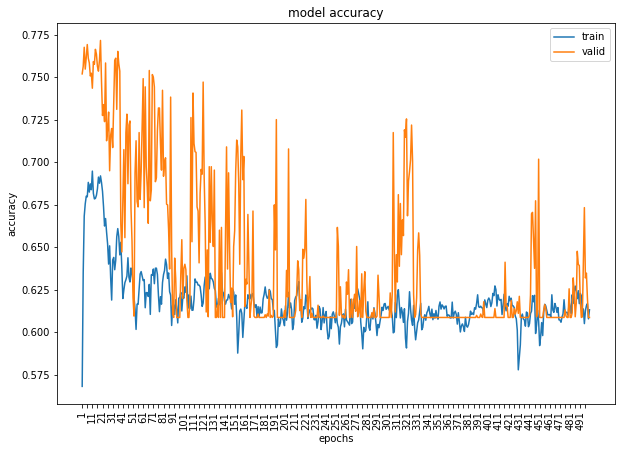

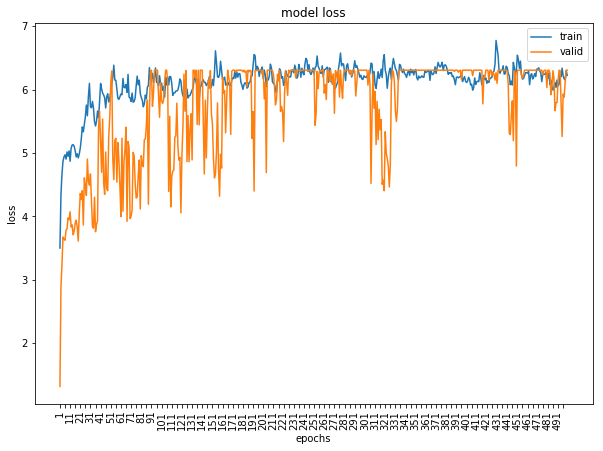

--> Training score:  0.5
--> Valid score:  0.5
------------
Params:  {'dropout_rate': 0.96, 'learn_rate': 0.07, 'hidden_layers': 1}


KeyboardInterrupt: 

In [17]:
optimising_hyperparameter = 'dropout_rate'
values = [0.80, 0.82, 0.84, 0.86, 0.88, 0.90, 0.92, 0.94, 0.96, 0.98]
results_df = pd.DataFrame(columns=[optimising_hyperparameter, 'train_score', 'valid_score'])

for ix,v in enumerate(values):
    
    params = {}
    params[optimising_hyperparameter] = v
    params['learn_rate'] = 0.05
    params['hidden_layers'] = 1
    
    train_score, valid_score, m = train_model(X_train, y_train, X_val, y_val,
                                               params=params, epochs=epochs, batch_size=batch_size)
    
    results_df.loc[ix, optimising_hyperparameter] = v
    results_df.loc[ix, 'train_score'] = train_score
    results_df.loc[ix, 'valid_score'] = valid_score

print("===== Overall =====")
print(results_df)
plot_neural_net_hyperparam(results_df, optimising_hyperparameter, 'train_score', 'valid_score')

## Weight constraint

In [ ]:
optimising_hyperparameter = 'weight_constraint'
values = [0.1, 0.25, 0.5, 1, 1.5, 2, 2.5, 3, 5]
results_df = pd.DataFrame(columns=[optimising_hyperparameter, 'train_score', 'valid_score'])

for ix,v in enumerate(values):
    
    params = {}
    params[optimising_hyperparameter] = v
    params['learn_rate'] = 0.05
    params['hidden_layers'] = 1
    params['dropout_rate'] = 0.92
    
    train_score, valid_score, m = train_model(X_train, y_train, X_val, y_val,
                                               params=params, epochs=epochs, batch_size=batch_size)
        
    results_df.loc[ix, optimising_hyperparameter] = v
    results_df.loc[ix, 'train_score'] = train_score
    results_df.loc[ix, 'valid_score'] = valid_score

print("===== Overall =====")
print(results_df)
plot_neural_net_hyperparam(results_df, optimising_hyperparameter, 'train_score', 'valid_score')

## Momentum

In [ ]:
optimising_hyperparameter = 'momentum'
values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results_df = pd.DataFrame(columns=[optimising_hyperparameter, 'train_score', 'valid_score'])

for ix,v in enumerate(values):
    
    params = {}
    params[optimising_hyperparameter] = v
    params['learn_rate'] = 0.05
    params['hidden_layers'] = 1
    params['dropout_rate'] = 0.92
    params['weight_constraint'] = 1
    
    train_score, valid_score, m = train_model(X_train, y_train, X_val, y_val,
                                               params=params, epochs=epochs, batch_size=batch_size)
        
    results_df.loc[ix, optimising_hyperparameter] = v
    results_df.loc[ix, 'train_score'] = train_score
    results_df.loc[ix, 'valid_score'] = valid_score

print("===== Overall =====")
print(results_df)
plot_neural_net_hyperparam(results_df, optimising_hyperparameter, 'train_score', 'valid_score')

## Final training run

------------
Params:  {'learn_rate': 0.05, 'hidden_layers': 1, 'dropout_rate': 0.92, 'weight_constraint': 1, 'momentum': 0.3}


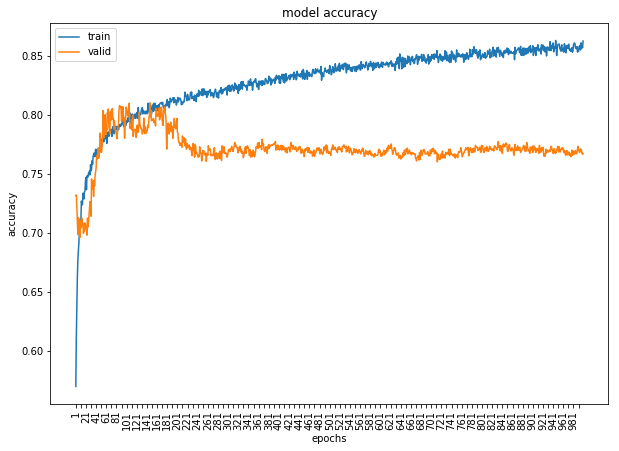

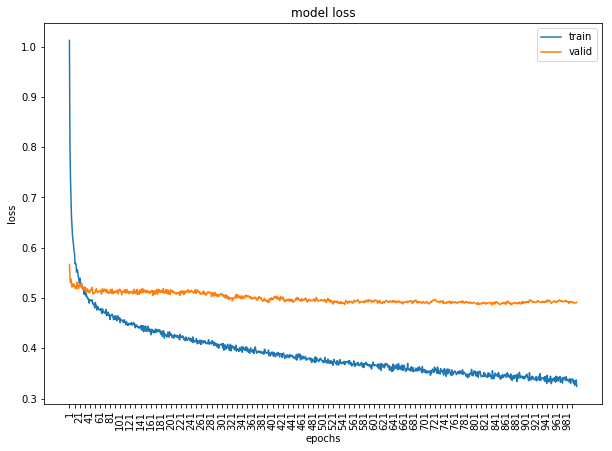

--> Training score:  0.9554816512138513
--> Valid score:  0.8652833696736135
<class 'keras.engine.sequential.Sequential'>


In [18]:
params = {}
params['learn_rate'] = 0.05
params['hidden_layers'] = 1
params['dropout_rate'] = 0.92
params['weight_constraint'] = 1
params['momentum'] = 0.3
    
train_score, valid_score, model = train_model(X_train, y_train, X_val, y_val,
                                               params=params, epochs=1000, batch_size=batch_size)
print(type(model))

In [26]:
# Save model as Pickle
to_s3(obj=model, bucket='mimic-jamesi', filepath='models/neural_network')